# Develop Cloudsat/ERA visualizations

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon, Point, box
import datetime

from pyhdf.SD import SD, SDC
from pyhdf.HDF import *
from pyhdf.VS import *

from netCDF4 import Dataset
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.transform import from_bounds

data_path = os.path.join('/','Users','Lucien','Documents','cloudsat_project','data')
default_crs = 'epsg:3995'

## Custom Functions

In [2]:
#=============================================================================================
# Functions to set up plot. 

def specify_area_of_interest_EPSG4326(bbox=(-180,60,180,90)): 
    area_of_int = gpd.GeoDataFrame({'geometry':[box(*bbox)]})
    area_of_int.crs = {'init':'epsg:4326'}
    return area_of_int


def specify_area_of_interest_EPSG3995(bbox=(-3e6,-3e6,3e6,3e6)): 
    area_of_int = gpd.GeoDataFrame({'geometry':[box(*bbox)]})
    area_of_int.crs = {'init':default_crs}
    return area_of_int


def load_country_geometries(area_of_interest):
    countries = gpd.read_file(os.path.join(data_path,'Countries_WGS84','Countries_WGS84.shp'))
    countries = countries.to_crs({'init':default_crs})
    countries = gpd.overlay(countries,area_of_interest,how='intersection')
    return countries


def prepare_polygon_coords_for_bokeh(countries): 
    """Need to go from a list of points to two lists of lists (one for x and y coordinates). 
    For each list of lists, the inner lists contain the x or y coordinates for each point in
    a single polygon, while the outer list has one element for each polygon. 
    """
    
    # Simplify shapes (to resolution of 10000 meters), convert polygons to multipolygons. 
    list_of_polygons = []
    for raw_poly in countries['geometry']: 
        raw_poly = raw_poly.simplify(10000, preserve_topology=False)
        if isinstance(raw_poly,Polygon): 
            raw_poly = MultiPolygon([raw_poly])
        for poly in list(raw_poly): 
            list_of_polygons.append(poly)
            
    # Create lists of lists. 
    x_coords = [list(poly.exterior.coords.xy[0]) for poly in list_of_polygons]
    y_coords = [list(poly.exterior.coords.xy[1]) for poly in list_of_polygons]
    
    return x_coords,y_coords


#=============================================================================================
# Functions for reading data from HDF-EOS files. 

def read_datasets(FILENAME): 
    """Reads all datasets in the file, places fill_values with NaNs, and places in dictionary."""
    # Open the file
    file = SD(FILENAME, SDC.READ)
    datasets_dict = file.datasets()
    dataset_names = [dname for dname in datasets_dict.keys()]

    # Extract a single dataset from the file, replace the fill values with NaN. 
    data_dict = {}
    for ds in dataset_names: 
        sds_obj = file.select(ds) 
        data = sds_obj.get() 
        fill_val = sds_obj.attributes().get('_FillValue')
        if fill_val: 
            data = data.astype(np.float32)
            data[data==fill_val] = np.NaN
        data_dict[ds] = data

    return data_dict


def read_vdata(FILENAME): 
    """Reads all vdata fields in the file and places in dictionary."""
    # Prepare to read the data. 
    f = HDF(FILENAME, SDC.READ)        # Open the file
    vs = f.vstart()                    # Start the vdata interface
    data_info_list = vs.vdatainfo()    # List the vdata fields
    vdata_fieldnames = [a[0] for a in data_info_list]    # Get the names

    # Load the data, place in dictionary
    vdata_dict = {}     
    for field in vdata_fieldnames: 
        vdata_dict[field] = np.squeeze(np.asarray(vs.attach(field)[:]))

    # terminate the vdata interface, close the file. 
    vs.end() 
    f.close()

    return vdata_dict


def add_datetime(vdata_dict,FILENAME):
    """Adds a datetime vector (for time of each measurement) to the vdata_dict"""
    first_second = np.around(vdata_dict['UTC_start'],decimals=-2)
    first_dtime  = np.asarray(datetime.datetime.strptime(FILENAME.split('/')[-1][:13],'%Y%j%H%M%S'))\
                             .astype('datetime64[D]')+pd.Timedelta(str(first_second)+' seconds')
    tv = first_dtime+(np.around(vdata_dict['Profile_time'],decimals=2)*pd.Timedelta('1 seconds'))
    time_vec = np.asarray([pd.Timestamp(t) for t in tv])
    vdata_dict['datetime'] = time_vec
    return vdata_dict


def read_cloudsat_file(FILENAME): 
    """Reads an entire CloudSat file (HDF-EOS format)"""

    data_dict = read_datasets(FILENAME)
    vdata_dict = read_vdata(FILENAME)
    vdata_dict = add_datetime(vdata_dict,FILENAME)
      
    return data_dict,vdata_dict


## Custom radarPass class
This class will hold all the data for each plot in a standardized format

In [3]:
class radarPass: 
    """Class for the radar pass... will hold all the relevant data!"""
    
    def __init__(self,lon,lat,timestamp,height,radar_refl,cpr_cloud_mask):
        
        # Data for the full pass
        self.lon_full = lon
        self.lat_full = lat
        self.timestamp_full = timestamp
        self.radar_refl_full = radar_refl
        self.cpr_cloud_mask_full = cpr_cloud_mask
        self.height = height
        
        # Data for trimmed pass
        self.lon = lon
        self.lat = lat
        self.timestamp = timestamp
        self.radar_refl = radar_refl
        self.cpr_cloud_mask = cpr_cloud_mask
        
        # For dealing with cloud classification data
        self.cloud_dict = {
            '0000': (0,'None'), 
            '0001': (1,'Ci'), 
            '0010': (2,'As'), 
            '0011': (3,'Ac'),
            '0100': (4,'St'),
            '0101': (5,'Sc'),
            '0110': (6,'Cu'),
            '0111': (7,'Ns'),
            '1000': (8,'Deep')
        }
        self.precip_dict = {
            '00': (0,'no precipitation'),
            '01': (1,'liquid precipitation'),
            '10': (2,'solid precipitation'), 
            '11': (3,'possible drizzle')
        }
    
    def add_cloudclass(self, cldclass_data, cldclass_vdata): 
        if (all(self.lon_full[:5] == cldclass_vdata["Longitude"][:5]) and 
            all(self.lat_full[:5] == cldclass_vdata["Latitude"][:5])): 
            
            # All the cloud class and precipitation type information in stored in a binary format. 
            # Need to decode the binary to retrieve the information. 
            self.cloud_class_full = np.flipud(cldclass_data['cloud_scenario'].T)
            binary_cc = [["{0:b}".format(val) for val in line]  for line in 
                         self.cloud_class_full.tolist()]
            self.cloud_type_full = np.asarray([[self.cloud_dict[val[-5:-1]][0] for val in line] 
                                               for line in binary_cc])
            self.precip_type_full = np.asarray([[self.precip_dict[val[-14:-12]][0] if len(val)>12 else -1 
                                                 for val in line] for line in binary_cc])
            
        else: 
            # Set fields equal to None if the lat/lon data from the two files doesn't match. Means that 
            # the two files are incompatible. 
            self.cloud_class_full = None
            self.cloud_type_full  = None
            self.precip_type_full = None
            print("Cloud classification file doesn't match up with this radar pass.") 
            
        return self
    
    def trim_pass(self,area_of_interest): 
        """Trim the radar pass so that it only contains profiles in the 'area of interest' 
        (which is given in the default_crs).
        """
        
        def determine_trim_indices(radar_pass,area_of_interest): 
            """Determine which profile indices will be kept after the trimming."""
            points = [Point(lon,lat) for lon,lat in zip(radar_pass.lon,radar_pass.lat)]
            traj_gdf = gpd.GeoDataFrame({'idx':list(range(len(radar_pass.lon))),'geometry':points})
            traj_gdf.crs = {'init':'epsg:4326'}
            traj_gdf = traj_gdf.to_crs({'init':default_crs})
            traj_gdf = gpd.sjoin(traj_gdf,area_of_interest,how='inner',op='within')\
                          .drop('index_right',axis=1)
            inds_to_keep = np.asarray(traj_gdf['idx'])
            return inds_to_keep
        
        inds_to_keep = determine_trim_indices(self,area_of_interest)
        
        self.lon = self.lon_full[inds_to_keep]
        self.lat = self.lat_full[inds_to_keep]
        self.timestamp = self.timestamp_full[inds_to_keep]
        self.radar_refl = self.radar_refl_full[:,inds_to_keep]
        self.cpr_cloud_mask = self.cpr_cloud_mask_full[:,inds_to_keep]
        try: 
            self.cloud_class = self.cloud_class_full[:,inds_to_keep]
            self.cloud_type = self.cloud_type_full[:,inds_to_keep]
            self.precip_type = self.precip_type_full[:,inds_to_keep]
        except: 
            self.cloud_class = None
            self.cloud_type = None
            self.precip_type = None
        self.trim_inds = inds_to_keep
        
        return self
    
    def add_era5_data(self):
        """Adds ERA5 fields to the radar pass. The date/hour for those fields is determined by 
        rounding the median time in the satellite's pass through the Arctic to the nearest hour. 
        
        PARAMETERS: 
        self 
        
        RETURNS:
        self, with one additional attribute called 'era5'. 'era5' is a dictionary that contains 
        all the era5 data, including the x coordinates, y coordinates, and atmospheric variables. 
        """
        
        def find_era_date_hour(radar_pass):
            """Identifies the date/hour in the ERA data that's closest to the middle of 
            the satellite's pass through the Arctic.
            """
            t = radar_pass.timestamp[len(radar_pass.timestamp)//2]
            if t.minute >= 30:
                rounded_time = t.replace(second=0, microsecond=0, minute=0, hour=t.hour+1)
            else:
                rounded_time = t.replace(second=0, microsecond=0, minute=0)
            return datetime.datetime.strftime(rounded_time,'%Y%m%d'), rounded_time.hour

        
        def open_atmospheric_vbls_file(radar_pass):
            """Opens ERA5 'atmospheric variables' file that corresponds to the given radar pass. 
            Returns the file handle and the hour of data in the file that corresponds 
            to the radar pass. 
            """
            dstr,hr = find_era_date_hour(radar_pass)
            file = 'ERA5_atmospheric_vbls_'+dstr+'.nc'
            atm_dataset = Dataset(os.path.join(data_path,'ERA5',file))

            return atm_dataset,hr

        
        def open_singlelevel_vbls_file(radar_pass): 
            """Opens ERA5 'single level variables' file that corresponds to the given radar pass. 
            Returns the file handle and the hour of data in the file that corresponds 
            to the radar pass. 
            """
            dstr,hr = find_era_date_hour(radar_pass)
            file = 'ERA5_singlelevel_vbls_'+dstr+'.nc'
            slev_dataset = Dataset(os.path.join(data_path,'ERA5',file))

            return slev_dataset,hr
        
        
        def reproject_from_epsg4326(lon,lat,field,dst_crs):
            """Reproject ERA5 field from lat/lon coordinates to specified destination crs."""
            # Parameters needed for the transformation. 
            width = field.shape[1]
            height = field.shape[0]
            left,bottom,right,top = lon[0],lat[-1],lon[-1],lat[0]
            src_crs = {'init':'epsg:4326'}

            # Calculate affine transformation matrix for the source field. 
            src_transform = from_bounds(left, bottom, right, top, width, height)

            # Calculate affine transformation matrix, width, and height for the destination field.
            dst_transform, dst_width, dst_height = calculate_default_transform(src_crs, dst_crs, width, 
                                                                               height, left = left, 
                                                                               bottom = bottom, 
                                                                               right = right, top = top)

            # Perform reprojection. 
            destination_array = np.zeros((dst_height,dst_width))
            reproject(source=field, destination=destination_array, src_transform=src_transform,
                      src_crs=src_crs, dst_transform=dst_transform, 
                      dst_crs=dst_crs, resampling=Resampling.nearest)

            # Replace fill values with NaN's. 
            destination_array[destination_array==1e20] = np.NaN

            # Get X and Y vectors for the transformed field. I could be doing this wrong, 
            # but my method definitely works for this specific Arctic case! 
            dst_x = np.linspace(dst_transform[2],dst_transform[5],dst_width)
            dst_y = np.linspace(dst_transform[2],dst_transform[5],dst_height)

            return dst_x,dst_y,destination_array

        
        def get_lat_lon_level_hours(atm_dataset): 
            """Extracts latitude, longitude, time, and level vectors from netCDF dataset."""
            lat = atm_dataset.variables['latitude'][:]
            lon = atm_dataset.variables['longitude'][:]
            hours = np.array([(pd.Timestamp('19000101')+(hrs_since*pd.Timedelta('1 hours'))).hour 
                              for hrs_since in atm_dataset.variables['time'][:]])
            if 'level' in atm_dataset.variables.keys(): 
                levels = atm_dataset.variables['level'][:]
            else: 
                levels = None
            return lat,lon,hours,levels


        def get_weather_variable_names(atm_dataset):
            """Retrieves names of netCDF variables that correspond to weather variables (and 
            therefore aren't the latitude, longitude, atmospheric level, or time).
            """
            return [var for var in atm_dataset.variables.keys() if var not in 
                   ['longitude', 'latitude', 'level', 'time']]

        
        def add_era5_atmospheric_vbls(atm_dataset,hr,era5={}):
            """Adds ERA5 variables that are only available at atmospheric levels 
            to the 'era5' dictionary.
            """

            lat,lon,hours,levels = get_lat_lon_level_hours(atm_dataset)
            wx_vbls = get_weather_variable_names(atm_dataset)

            for vbl in wx_vbls: 
                for level in levels:
                    i_time = np.where(hours==hr)[0][0]
                    i_level = np.where(levels==level)[0][0]
                    field = atm_dataset.variables[vbl][i_time,i_level,:,:]
                    reproj_x,reproj_y,reproj_field = reproject_from_epsg4326(lon,lat,field,
                                                                             {'init':default_crs})
                    era5[vbl+'_'+str(level)] = np.flipud(reproj_field).tolist()

            era5['x'],era5['y'] = reproj_x, reproj_y

            return era5

        
        def add_era5_singlelevel_vbls(slev_dataset,hr,era5={}):
            """Adds ERA5 variables that are only available at the surface to the 'era5' 
            dictionary.
            """

            lat,lon,hours,_ = get_lat_lon_level_hours(slev_dataset)
            wx_vbls = get_weather_variable_names(slev_dataset)

            for vbl in wx_vbls: 
                i_time = np.where(hours==hr)[0][0]
                field = slev_dataset.variables[vbl][i_time,:,:]
                reproj_x,reproj_y,reproj_field = reproject_from_epsg4326(lon,lat,field,
                                                                         {'init':default_crs})
                era5[vbl] = np.flipud(reproj_field).tolist()

            if 'x' not in era5.keys() and 'y' not in era5.keys(): 
                era5['x'],era5['y'] = reproj_x, reproj_y

            return era5

        atm_dataset,hr = open_atmospheric_vbls_file(self)
        era5 = add_era5_atmospheric_vbls(atm_dataset,hr,era5={})
        slev_dataset,hr = open_singlelevel_vbls_file(self)
        era5 = add_era5_singlelevel_vbls(slev_dataset,hr,era5=era5)
        self.era5 = era5
        
        return self

## Prepare to create plot
* Specify area of interest (everywhere in box (W,S,E,N) (-3e6,-3e6,3e6,3e6) in the polar stereographic coordinate system). A.K.A. just the Arctic. 
* Load geometries for all the countries. 
* Isolate country polygons that are at least partially in the area of interest. 
* Prepare those country geometries for plotting in Bokeh.  

In [10]:
area_of_interest = specify_area_of_interest_EPSG3995()
countries = load_country_geometries(area_of_interest)
x_poly_coords,y_poly_coords = prepare_polygon_coords_for_bokeh(countries)

## Put together radarPass instance
* Load cloudsat data. Good tutorial [here](https://www.science-emergence.com/Articles/How-to-read-CloudSat-2B-GEOPROF-GRANULE-HDF4-file-using-python-and-pyhdf-/). 
* Initialize `radarPass` class object to store all the important information for the radar pass. 
* Trim the `radarPass` object so that it only contains measurements in the area of interest. 
* Extract the x-coords, y-coords, and times needed to plot the satellite trajectory on the bokeh plots. 
* Also add the ERA5 data. 
* Fields: 
  * Temperature at 850mb, 700mb
  * Specific humidity at 850mb, 700mb
  * Specific cloud liquid water content at 850mb, 700mb
  * Specific cloud ice water content at 850mb, 700mb
  * Vertical velocity at 850mb, 700mb
  * Geopotential at 850mb, 700mb
  * U component of wind at 850mb, 700mb
  * V component of wind at 850mb, 700mb
  * Surface pressure
  * Mean sea level pressure
  * 2 metre temperature
  * 2 metre dewpoint temperature
* Location: (N,W,S,E) = (90,-180,60,180) (everywhere above 60N)
* Year: 2015
* Month: September
* Days: 1
* Hours: 3

In [11]:
pass_id = '2015244002319_49702'

# Create radarPass instance using CloudSat GEOPROF file. 
geoprof_fname = os.path.join(data_path,'cloudsat',
                             pass_id+'_CS_2B-'+'GEOPROF'+'_GRANULE_P1_R05_E06_F00.hdf')
data_dict,vdata_dict = read_cloudsat_file(geoprof_fname)
radar_pass = radarPass(vdata_dict['Longitude'],vdata_dict['Latitude'],
                       vdata_dict['datetime'],np.ravel(data_dict['Height'][0,::-1]),
                       np.flipud(data_dict['Radar_Reflectivity'].T),
                       np.flipud(data_dict['CPR_Cloud_mask'].T))

# Add Cloud Classification data to the radar pass.
cldclass_fname = os.path.join(data_path,'cloudsat',
                              pass_id+'_CS_2B-'+'CLDCLASS'+'_GRANULE_P1_R05_E06_F00.hdf')
data_dict,vdata_dict = read_cloudsat_file(cldclass_fname)
radar_pass = radar_pass.add_cloudclass(data_dict,vdata_dict)

# Trim radar pass so that it only includes profiles within the 'area of interest'. 
radar_pass = radar_pass.trim_pass(area_of_interest)

# Add ERA5 fields to the radarPass instance. 
radar_pass = radar_pass.add_era5_data()

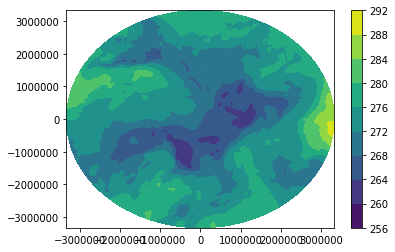

In [12]:
# Verify that the ERA5 retrieval was successful! 
plt.contourf(radar_pass.era5['x'],radar_pass.era5['y'],radar_pass.era5['t_850'])
plt.colorbar()

## Develop the plot

In [13]:
def get_radar_trajectory(radar_pass): 
    points = [Point(lon,lat) for lon,lat in zip(radar_pass.lon,radar_pass.lat)]
    traj_gdf = gpd.GeoDataFrame({'t':radar_pass.timestamp,'geometry':points})
    traj_gdf.crs = {'init':'epsg:4326'}
    traj_gdf = traj_gdf.to_crs({'init':default_crs})
    traj_gdf = traj_gdf.iloc[::40]
    x_traj = [pt.coords.xy[0][0] for pt in traj_gdf['geometry']]
    y_traj = [pt.coords.xy[1][0] for pt in traj_gdf['geometry']]
    t_traj = (traj_gdf['t']-traj_gdf['t'].iloc[0])/pd.Timedelta('1 minute')
    return x_traj,y_traj,t_traj

def prepare_image_for_plot(image,min_val,fill_min,max_val,fill_max): 
    image[image<=min_val] = fill_min
    image[image>=max_val] = fill_max
    return image

#def update_radar_plot(attr, old, new):
#    if select.value=="CloudSat: Radar Reflectivity":
#        img = prepare_image_for_plot(radar_pass.radar_refl.copy(),-2300,-3500,2000,2000) 
#    elif select.value=="CloudSat: Cloud Mask":
#        img = prepare_image_for_plot(radar_pass.cpr_cloud_mask.copy(),0,0,1e6,1e6)
#    sat_img_src = ColumnDataSource({'image':[img]})
#    sat_im.data_source = sat_img_src
#    return 

In [14]:
#era5_vbl = 'q_850'
#cloudsat_vbl = 'radar_refl'
radar_pass.__dict__.keys()

dict_keys(['lon_full', 'lat_full', 'timestamp_full', 'radar_refl_full', 'cpr_cloud_mask_full', 'height', 'lon', 'lat', 'timestamp', 'radar_refl', 'cpr_cloud_mask', 'cloud_dict', 'precip_dict', 'cloud_class_full', 'cloud_type_full', 'precip_type_full', 'cloud_class', 'cloud_type', 'precip_type', 'trim_inds', 'era5'])

https://bokeh.pydata.org/en/latest/docs/gallery/image.html

In [15]:
from bokeh.io import show, output_file, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, CustomJS, LinearColorMapper, FixedTicker, ColorBar
from bokeh.palettes import Reds6
from bokeh.plotting import figure, save
from bokeh.resources import CDN
from bokeh.layouts import gridplot
from bokeh.models import Panel, Tabs
from bokeh.models.widgets import Select

output_notebook()

# Create column data sources for plots. Needed for hovertool callbacks. 
poly_src = ColumnDataSource({'x':x_poly_coords,'y':y_poly_coords})
x_traj_coords,y_traj_coords,t_traj = get_radar_trajectory(radar_pass)
traj_src = ColumnDataSource({'x':x_traj_coords,'y':y_traj_coords,'t':t_traj})
sat_src = ColumnDataSource({'t':[min(t_traj)+30,min(t_traj)+30],'y':[-5000,25000]})
era_img_src = ColumnDataSource({'image':[radar_pass.era5['q_700']]})

# Create the top figure--land patches, satellite trajectory line, 
# and satellite location circles. 
p1 = figure(title="CloudSat Trajectory, ERA5 Fields", toolbar_location="right", 
            plot_width=800, plot_height=550,x_range=(-3e6, 3e6), 
            y_range=(-3e6, 3e6))
color_mapper = LinearColorMapper(palette='Viridis9',low=0,high=0.009)
era_im = p1.image('image', source=era_img_src, x=radar_pass.era5['x'][0], 
                  y=radar_pass.era5['y'][0], 
                  dw=radar_pass.era5['x'][-1]-radar_pass.era5['x'][0], 
                  dh=radar_pass.era5['y'][-1]-radar_pass.era5['y'][0], 
                  color_mapper=color_mapper)
era_im.glyph.color_mapper.nan_color = (1, 1, 1, 0)
pr_cont = p1.patches('x', 'y', source=poly_src, fill_color='black', fill_alpha=0.0, 
                     line_color="black", line_width=0.8)
lr_traj = p1.line('x','y',source=traj_src,line_color='black',line_width=2)
cr_traj = p1.circle('x','y',source=traj_src,fill_color='black',fill_alpha=0.3,
                    line_color='black',line_alpha=0,hover_fill_color='green',
                    hover_fill_alpha=1,hover_line_color='black',hover_line_alpha=1,
                    size=5)

ticker = FixedTicker(ticks=[i/1000 for i in range(10)])
color_bar = ColorBar(color_mapper=color_mapper, bar_line_color='black',ticker=ticker,
                     major_tick_line_color='black',label_standoff=6, 
                     border_line_color=None, location=(0,0))
p1.add_layout(color_bar, 'right')


# Create the bottom figure

# Radar reflectivity
img = prepare_image_for_plot(radar_pass.radar_refl.copy(),-2300,np.nan,1500,1500)
sat_img_src1 = ColumnDataSource({'image':[img]})
color_mapper = LinearColorMapper(palette='Plasma256',low=-2300,high=1500)
#ticker = FixedTicker(ticks=[4*i for i in range(11)])
color_bar = ColorBar(color_mapper=color_mapper, bar_line_color='black',
                     major_tick_line_color='black',label_standoff=8, 
                     border_line_color=None, location=(0,0))

p_refl = figure(title="CloudSat: Radar Reflectivity", toolbar_location="right",
            plot_width=800, plot_height=250, 
            x_range=(min(t_traj), max(t_traj)),y_range=(0, 15000))

sat_im = p_refl.image('image', source=sat_img_src1, x=min(t_traj), 
                  y=radar_pass.height[0], dw=max(t_traj), 
                  dh=(radar_pass.height[-1]-radar_pass.height[0]), 
                  color_mapper=color_mapper)
sat_im.glyph.color_mapper.nan_color = (0, 0, 0, 1)

lr_sat = p_refl.line('t','y',source=sat_src,line_color='white',line_width=3)
p_refl.xaxis.axis_label = 'Time since start of trajectory (min)'
p_refl.yaxis.axis_label = 'Height (m)'
p_refl.add_layout(color_bar, 'right')


# CPR Cloud mask
#img = prepare_image_for_plot(radar_pass.cpr_cloud_mask.copy(),0,0,100,100)
#sat_img_src2 = ColumnDataSource({'image':[img]})
#color_mapper = LinearColorMapper(palette='Paired11',low=-2,high=42)
#ticker = FixedTicker(ticks=[4*i for i in range(11)])
#color_bar = ColorBar(color_mapper=color_mapper, bar_line_color='black',ticker=ticker,
#                     major_tick_line_color='black',label_standoff=6, 
#                     border_line_color=None, location=(0,0))
#
#p_mask = figure(title="CloudSat: CPR Cloud Mask", toolbar_location="right",
#            plot_width=800, plot_height=250, 
#            x_range=(min(t_traj), max(t_traj)),y_range=(0, 15000))
#sat_im = p_mask.image('image', source=sat_img_src2, x=min(t_traj), 
#                  y=radar_pass.height[0], dw=max(t_traj), 
#                  dh=(radar_pass.height[-1]-radar_pass.height[0]), 
#                  color_mapper=color_mapper)
#lr_sat = p_mask.line('t','y',source=sat_src,line_color='white',line_width=3)
#
#p_mask.xaxis.axis_label = 'Time since start of trajectory (min)'
#p_mask.yaxis.axis_label = 'Height (m)'
#p_mask.add_layout(color_bar, 'right')


# Cloud classification
img = prepare_image_for_plot(radar_pass.cloud_type.copy(),0,0,10,10)
sat_img_src3 = ColumnDataSource({'image':[img]})
color_mapper = LinearColorMapper(palette='Paired9',low=-0.5,high=8.5)
ticker = FixedTicker(ticks=[i for i in range(9)])
color_bar = ColorBar(color_mapper=color_mapper, bar_line_color='black',ticker=ticker,
                     major_tick_line_color='black',label_standoff=6, 
                     border_line_color=None, location=(0,0))

title_key = ', '.join([str(a[0])+'-'+a[1] for a in radar_pass.cloud_dict.values()])
p_class = figure(title="CloudSat: Cloud Types, key: "+title_key, toolbar_location="right",
            plot_width=800, plot_height=250, 
            x_range=(min(t_traj), max(t_traj)),y_range=(0, 15000))
sat_im = p_class.image('image', source=sat_img_src3, x=min(t_traj), 
                  y=radar_pass.height[0], dw=max(t_traj), 
                  dh=(radar_pass.height[-1]-radar_pass.height[0]), 
                  color_mapper=color_mapper)
lr_sat = p_class.line('t','y',source=sat_src,line_color='white',line_width=3)

p_class.xaxis.axis_label = 'Time since start of trajectory (min)'
p_class.yaxis.axis_label = 'Height (m)'
p_class.add_layout(color_bar, 'right')

# Add as tabs...
tab_refl = Panel(child=p_refl, title="refl")
#tab_mask = Panel(child=p_mask, title="cld_mask")
tab_class = Panel(child=p_class, title="cld_type")
radar_tabs = Tabs(tabs=[tab_refl,tab_class])

# Create the JS callback for vertical line on radar plots. 
callback_htool = CustomJS(args={'traj_src':traj_src,'sat_src':sat_src}, code="""
    const indices = cb_data.index["1d"].indices[0];
        
    var data_traj = traj_src.data
    var t_traj = data_traj['t']
    const t_val = t_traj[indices]
    
    var data_sat = sat_src.data;
    var t_sat = data_sat['t']
    t_sat[0] = t_val
    t_sat[1] = t_val
    sat_src.change.emit(); 
""")

# Add the hovertool to the satellite trajectory points on the map. 
htool_mode = ('vline' if max(y_traj_coords)-min(y_traj_coords)<=
                          (max(x_traj_coords)-min(x_traj_coords)) else 'hline')
tooltips1 = [("x", "@x"),("y", "@y"),('t','@t')]
p1.add_tools(HoverTool(renderers=[cr_traj],callback=callback_htool,
                       mode=htool_mode,tooltips=tooltips1))

layout = gridplot([[p1], [radar_tabs]])
show(layout)






# Add select menu to change radar variables
#callback_radar_select = CustomJS(args={"sat_img_src":sat_img_src, "select_radar":select_radar}, code="""
#    var field_select = {"radar_refl":sat_img_src.data["radar_refl"],
#                        "cpr_cloud_mask":sat_img_src.data["cpr_cloud_mask"]}
#    if (select_radar.value == "CloudSat: Radar Reflectivity"){
#        sat_img_src.data["image"] = JSON.parse(JSON.stringify(sat_img_src.data["radar_refl"]))
#    } else if (select_radar.value == "CloudSat: Cloud Mask"){
#        sat_img_src.data["image"] = JSON.parse(JSON.stringify(sat_img_src.data["cpr_cloud_mask"]))
#    } 
#    sat_img_src.change.emit()
#""")

#img = prepare_image_for_plot(radar_pass.radar_refl.copy(),-2300,-3500,2000,2000)
#sat_img_src = ColumnDataSource({'image':[img],'radar_refl':[np.array(radar_pass.radar_refl)],
#                                'cpr_cloud_mask':[np.array(radar_pass.cpr_cloud_mask)]})

#sel_options = ['CloudSat: Radar Reflectivity', 'CloudSat: Cloud Mask']
#select_radar = Select(title="Satellite observation type:",  options=sel_options, 
#                value="CloudSat: Radar Reflectivity", width=250, callback=callback_radar_select)

#sel_options = ['Temperature 700 mb', 'Humidity 700 mb']
#select_era5 = Select(title="ERA5 field name:",  options=sel_options, 
#                value="Temperature 700 mb", width=250)

#select.on_change('value', update_radar_plot)



Loading BokehJS ...

/Users/Lucien/anaconda/envs/flux-tailor/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater_equal
  


ValueError: Out of range float values are not JSON compliant

(0, 15000)

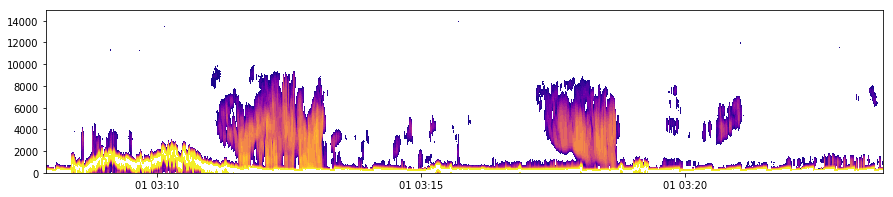

In [24]:
fig = plt.figure(figsize=[15,3])
plt.contourf(radar_pass.timestamp,radar_pass.height,radar_pass.radar_refl,
             levels=np.linspace(-2300,2000,20),cmap=plt.get_cmap('plasma'))
plt.ylim([0,15000])
#plt.xlim(['2015-09-01 03:10','2015-09-01 03:20'])